# Duplicate Real Estate Listings 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from tqdm import tqdm
import os
import uuid
import matplotlib.pyplot as plt
import hashlib
from PIL import Image
import requests
from io import BytesIO
import glob
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme({
    "valid": "bold green encircle",
    "info": "dim cyan",
    "warning": "magenta",
    "danger": "bold red"
})
console = Console(theme=custom_theme)


pd.options.display.max_rows=50
pd.options.display.max_columns=90
df = pd.read_csv("data/Dataset - Ads _ Levallois-Perret - 2019-08 - export-ads-levallois-perret-2019-08-27.csv")

## 1. Data Exploration

In [2]:
for type in df.dtypes.unique():
    same_dtype_columns = df.select_dtypes(include=type).columns
    console.print(f"\n[bold]Data type[/bold] : {type} \n[bold]Columns[/bold] : {list(same_dtype_columns)} \n")

Data type : object 
Columns : ['ID', 'URL', 'CRAWL_SOURCE', 'PROPERTY_TYPE', 'NEW_BUILD', 'DESCRIPTION', 'IMAGES', 'FURNISHED', 
'HEATING_TYPES', 'HEATING_MODE', 'ELEVATOR', 'CARETAKER', 'MARKETING_TYPE', 'PRICE_EVENTS', 
'RENTAL_EXPENSES_INCLUDED', 'FEES_INCLUDED', 'AGENCIES_UNWANTED', 'OCCUPIED', 'DEALER_NAME', 'DEALER_TYPE', 'CITY',
'PUBLICATION_START_DATE', 'LAST_CRAWL_DATE', 'LAST_PRICE_DECREASE_DATE']

Data type : float64 
Columns : ['SURFACE', 'LAND_SURFACE', 'BALCONY_SURFACE', 'TERRACE_SURFACE', 'ROOM_COUNT', 'BEDROOM_COUNT', 
'BATHROOM_COUNT', 'LUNCHROOM_COUNT', 'TOILET_COUNT', 'FIREPLACE', 'AIR_CONDITIONING', 'GARDEN', 'SWIMMING_POOL', 
'BALCONY', 'TERRACE', 'CELLAR', 'PARKING_COUNT', 'FLOOR', 'FLOOR_COUNT', 'CONSTRUCTION_YEAR', 'ENERGY_CONSUMPTION',
'GREENHOUSE_GAS_CONSUMPTION', 'PRICE', 'PRICE_M2', 'RENTAL_EXPENSES', 'DEPOSIT', 'FEES', 'ZIP_CODE', 
'PUBLICATION_END_DATE']

Data type : bool 
Columns : ['PARKING', 'EXCLUSIVE_MANDATE']

Data type : int64 
Columns : ['CITY_ID', 'DEPT_CODE']

In [3]:
def style_max(v, props=''):
    return props if v==100 else None

def show_na(df):
    na_cols = (pd.Series(df.isna().sum()/len(df.index)*100).reset_index().
        rename(columns={'index':'Feature',0:'Missing_Values'}).
        sort_values(by=['Missing_Values'], ascending=[False]))
    na_cols["Missing_Values"] = na_cols.apply(lambda row: round(row["Missing_Values"],2), axis=1)
    na_cols=na_cols[na_cols["Missing_Values"]>0]
    na_cols = na_cols.set_index('Feature')

    return na_cols

cm = sns.light_palette("red", as_cmap=True)

nas_stat = show_na(df)
nas_stat.style.set_caption("Pourcentage of missing values for each Feauture in the dataset")\
              .background_gradient(cmap=cm).applymap(style_max, props='color:black;')


,Missing_Values
Feature,
TOILET_COUNT,100.000000
GREENHOUSE_GAS_CONSUMPTION,100.000000
PUBLICATION_END_DATE,100.000000
AIR_CONDITIONING,100.000000
FIREPLACE,100.000000
CELLAR,100.000000
LUNCHROOM_COUNT,100.000000
BATHROOM_COUNT,100.000000
BALCONY_SURFACE,100.000000


In [4]:
empty_columns = nas_stat[nas_stat["Missing_Values"]==100].index
df.drop(columns=empty_columns, inplace=True)

In [5]:

def style_unique(v, props='', n=2164):
    return props if v==n else None

def style_constant(v, props=''):
    return props if v==1 else None

def show_card(df):
    df = (pd.Series({feature: len(df[feature].unique()) for feature in df.columns})
                        .reset_index().rename(columns={'index':'Feature',0:'Cardinality'}))
    df =df.set_index('Feature')
    return df.sort_values(by ='Cardinality', ascending=False )

card_stat = show_card(df)
card_stat.style.set_caption("Cardinality of each feature in the dataset").applymap(style_constant, props='background-color:red;color:white')\
    .applymap(style_unique, props='background-color:green;color:white', n=len(df))

,Cardinality
Feature,
ID,2164
URL,2164
LAST_CRAWL_DATE,2164
PUBLICATION_START_DATE,2103
IMAGES,1947
DESCRIPTION,1915
PRICE_EVENTS,1733
PRICE_M2,998
PRICE,765


In [6]:
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

In [7]:
def generate_unique_identifier(input_string):
    # Using SHA256 as the hashing algorithm
    hash_object = hashlib.sha256(input_string.encode())
    unique_identifier = hash_object.hexdigest()
    return unique_identifier

def download_df_images_locally(df, images_column_name = "IMAGES", id_column_name = "ID", export_path ="data/images/" ):

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):

        # parsing the array
        array_urls = json.loads(row[images_column_name])


        directory = f"{export_path}{row[id_column_name]}"

        if not os.path.exists(directory):
            os.makedirs(directory)

        # downloading the images
        for j, url in enumerate(array_urls):
            try : 
                img_name = generate_unique_identifier(url)
                save_image_path = f"{directory}/{img_name}.png"
                if os.path.exists(save_image_path):
                    continue
                else:
                    img = download_image(url)
                    img.save(save_image_path)                
            except Exception as e :
                continue
    



In [8]:
# download_df_images_locally(df)

## 2. Cleaning the dataset 

In [9]:
## Droping constant columns : 

In [10]:
df.drop(columns = ["CITY_ID", "CITY", "DEPT_CODE"], axis=1, inplace=True)

In [11]:
## Parsing Heating Types

In [12]:
heating_types = []
for value in df["HEATING_TYPES"].unique():
    heating_array = json.loads(value)
    heating_types.extend(heating_array)
print("Unique Heating Types are : ", heating_types)
def parse_heating_type(row, heating_types):
    for heating_type in heating_types:
        if heating_type in row["HEATING_TYPES"]:
            row[heating_type]=1
        else:
            row[heating_type]=0
    return row
df = df.apply(lambda row : parse_heating_type(row, heating_types=heating_types), axis=1)

Unique Heating Types are :  ['ELECTRIC', 'GAS', 'ELECTRIC', 'UNDERFLOOR', 'FUEL']


In [13]:
## Removing duplicate URLS from IMAGEs rows

In [14]:
df["IMAGES"] = df.apply(lambda row:list(set(json.loads(row["IMAGES"]))), axis=1)

In [15]:
## Adding the number of listed images and number of downloaded images

In [16]:
def count_urls(urls):
    #array_urls = json.loads(urls)
    return len(urls)

def count_images(id, data_path = "data/images/"):
    
    list_images = glob.glob( f"{data_path}{id}/*png")
    return len(list_images)

df["NUMBER_URL_IMAGES"]=df.apply(lambda row : count_urls(row["IMAGES"]), axis = 1)
df["NUMBER_VALID_IMAGES"]=df.apply(lambda row : count_images(row["ID"]), axis = 1)

In [17]:
df["IMAGES"].apply(lambda v : len(v))

df["IMAGES"].apply(lambda v : len(set(v)))

0        5
1        6
2       16
3        6
4       26
        ..
2159     5
2160     2
2161     0
2162     2
2163     4
Name: IMAGES, Length: 2164, dtype: int64

## 3. Dataset validation

In [18]:
import pytest 
import ipytest 
ipytest.config.rewrite_asserts=True 
__file___='notebook.ipynb'

In [23]:
df_test["IMAGES"].iloc[0]

"['https://cf-medias.avendrealouer.fr/image/_873908161_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908159_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908162_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908158_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908160_d.jpg']"

In [19]:
df_test = df.copy()

@pytest.mark.parametrize("df", [df_test])
def test_df_uniqueess(df):
    df["IMAGES"]=df["IMAGES"].apply(lambda v:str(v))
    console.print(f"There are : {df.duplicated().sum()} duplicate rows" )
    assert df.duplicated().sum()==0

@pytest.mark.parametrize("df", [df_test])
def test_url_uniqueness(df):
    console.print(f"There are : {len(df)-len(df['URL'].unique())} duplicate offer URLS" )
    assert len(df["URL"].unique())/len(df)==1

@pytest.mark.parametrize("df", [df_test])
def test_id_uniqueness(df):
    console.print(f"There are : {len(df)-len(df['ID'].unique())} duplicate IDS" )
    assert len(df["ID"].unique())/len(df)==1

@pytest.mark.parametrize("df", [df_test])
def test_duplicate_descriptions(df):
    console.print(f"There are : {df['DESCRIPTION'].duplicated().sum()} duplicate Descriptions" )
    assert df["DESCRIPTION"].duplicated().sum()==0

@pytest.mark.parametrize("df", [df_test])
def test_duplicate_price_events(df):
    console.print(f"There are : {df['PRICE_EVENTS'].duplicated().sum()} duplicate PRICE_EVENTS" )
    assert df["PRICE_EVENTS"].duplicated().sum()==0
    
@pytest.mark.parametrize("df", [df_test])
def test_duplicate_publication_start_date(df):
    console.print(f"There are : {df['PUBLICATION_START_DATE'].duplicated().sum()} duplicate PUBLICATION_START_DATE" )
    assert df["PUBLICATION_START_DATE"].duplicated().sum()==0
    
@pytest.mark.parametrize("df", [df_test])
def test_duplicate_images_url_same_rows(df):
    # Create an empty list to store duplicated URLs
    duplicated_urls = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Extract the list of URLs from the row
        url_list = row['IMAGES']
        print(url_list[0])
        # Check for duplicate URLs within the list
        if len(url_list) != len(set(url_list)):
            print(url_list)
            print(len(url_list), len(set(url_list)))
            # Append the row index to the duplicated_urls list
            duplicated_urls.append(index)
            
    console.print(f"There are {len(duplicated_urls)} with duplicate instances of images url")
    assert len(duplicated_urls)==0

@pytest.mark.parametrize("df", [df_test])
def test_url_validity(df):
    invalid = df["NUMBER_URL_IMAGES"].sum()-df["NUMBER_VALID_IMAGES"].sum()
    percent=100*invalid/df["NUMBER_URL_IMAGES"].sum()
    console.print(f"There are : {invalid} invalid Image URLS ({percent:.2f}%)" )
    assert invalid==0





In [20]:
ipytest.run("-s")

======================================= test session starts ========================================
platform linux -- Python 3.8.16, pytest-7.3.2, pluggy-1.0.0
rootdir: /home/odeck/Desktop/duplicate-ads
plugins: anyio-3.5.0
collected 8 items

t_ec93b045b6e549edbc6306820cfaedd5.py 

There are : 0 duplicate rows

.

There are : 0 duplicate offer URLS

.

There are : 0 duplicate IDS

.

There are : 249 duplicate Descriptions

F

There are : 431 duplicate PRICE_EVENTS

F

There are : 61 duplicate PUBLICATION_START_DATE

F[
['https://cf-medias.avendrealouer.fr/image/_873908161_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908159_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908162_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908158_d.jpg', 'https://cf-medias.avendrealouer.fr/image/_873908160_d.jpg']
305 38
[
['http://photos.ubiflow.net/440414/165474561/photos/5.jpg?20190401022226', 'http://photos.ubiflow.net/440414/165474561/photos/4.jpg?20190401022226', 'http://photos.ubiflow.net/440414/165474561/photos/2.jpg?20190401022226', 'http://photos.ubiflow.net/440414/165474561/photos/6.jpg?20190401022226', 'http://photos.ubiflow.net/440414/165474561/photos/3.jpg?20190401022226', 'http://photos.ubiflow.net/440414/165474561/photos/1.jpg?20190401022226']
444 33
[
['https://v.seloger.com/s/width/965/visuels/1/y/f/l/1yfl55uj9znq1j5q3go2pd2dcfwt2ixhbd73g0hds.jpg', 'https://v.seloger.com/s/width/965/visuels/0/9/3/7/0937mk01pff7dkq2n4dhqcwehdoaa4okzpmzc1zwg.jpg', 'https://v.seloger.com/s/widt

There are 2049 with duplicate instances of images url

F

There are : 3862 invalid Image URLS (30.79%)

F

============================================= FAILURES =============================================
_________________________________ test_duplicate_descriptions[df0] _________________________________

df =                                         ID  \
0     22c05930-0eb5-11e7-b53d-bbead8ba43fe   
1     8d092fa0-bb99-11e8-a...2162                  2                    2  
2163                  4                    0  

[2164 rows x 49 columns]

    @pytest.mark.parametrize("df", [df_test])
    def test_duplicate_descriptions(df):
        console.print(f"There are : {df['DESCRIPTION'].duplicated().sum()} duplicate Descriptions" )
>       assert df["DESCRIPTION"].duplicated().sum()==0
E       AssertionError

/tmp/ipykernel_518350/773586369.py:22: AssertionError
_________________________________ test_duplicate_price_events[df0] _________________________________

df =                                         ID  \
0     22c05930-0eb5-11e7-b53d-bbead8ba43fe   
1     8d092fa0-bb99-11e8-a.

<ExitCode.TESTS_FAILED: 1>

## 1. preparing the dataset :

A perfect solution to this problem would be to embed each offer into a an abstract space where each point or instance is a numerical representation of an offer. Then we can define a distance over such space. Duplicate offers or ads are the instances that have a `distance = 0` between each other. The main issue here is that two duplicate offers can have a `distance > 0`. For example, a user can post the same offer on two sites `bienici` and `leboncoin`. But post different number of pictures, or slightly change the description, add more info, etc between each site.

To solve this issue we'll try to solve this problem by two methods :

- Textual representation
- Image embeddings


####  Edge cases to look out for :

- Duplicate images of logos / Empty images / Floor plans
- Offer for rent and offer for sale at the same time can be counted as duplicates
- Information mismatch between duplicate offers in two different sites or posts

In [21]:
import fiftyone as fo
from tqdm import tqdm
import pandas as pd
import glob
import fiftyone.brain as fob
import fiftyone.core.utils as fou
from collections import Counter
from fiftyone import ViewField as F

In [22]:
def prepare_fiftyone_dataset(df):

    # Create samples for our data
    samples = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # price = y_train.iloc[i]["price"]
        # pred = y_pred.iloc[i]["price"]
        id_annonce= row["ID"]
        filepaths = glob.glob(f"data/images/{id_annonce}/*.png")
        # caption = caption_df.iloc[i]["features"]
        # caption=caption.replace('"', "'")
        # caption_split = caption.split("',")


        # Instances that have images 
        if(len(filepaths)>0):
            for j,filepath in enumerate(filepaths) :
                sample = fo.Sample(filepath=filepath)

                # computing the hash for individual images
                sample["file_hash"] = fou.compute_filehash(sample.filepath)
                sample["ID"]=id_annonce
                # for key in row.keys():
                #     sample[key]=row[key]
                # sample["price"]=fo.Regression(value=price) 
                # sample["y_pred"]= fo.Regression(value=pred) 
                # sample["caption"]=caption_split[j]
                # sample["description"]=row["DESCRIPTION"]

                samples.append(sample)
    return samples


In [23]:
samples = prepare_fiftyone_dataset(df)


100%|██████████| 2164/2164 [00:03<00:00, 680.52it/s]


In [24]:
dataset = fo.Dataset("Dataset-6")
dataset.add_samples(samples)
dataset.compute_metadata()

# Define some interesting plots
plot1 = fo.NumericalHistogram(F("metadata.size_bytes") / 1024, bins=50, xlabel="image size (KB)")
plot2 = fo.NumericalHistogram("predictions.detections.confidence", bins=50, range=[0, 1])
plot3 = fo.CategoricalHistogram("ground_truth.detections.label", order="frequency")
plot4 = fo.CategoricalHistogram("predictions.detections.label", order="frequency")

ValueError: Dataset name 'Dataset-6' is not available

In [ ]:
plots = [plot1, plot2, plot3, plot4]
plot = fo.ViewGrid(plots)
plot.show(height=720)
# plot.save("./histogram.jpg", scale=2.0)



In [ ]:
session = fo.launch_app(dataset)

In [ ]:
results = fob.compute_uniqueness(dataset)
plot = results.visualize(labels="uniqueness", axis_equal=True)
# plot.save("./embeddings.png", height=300, width=800)
# figure = results.plot_confusion_matrix(
#     classes=classes, backend="matplotlib", figsize=(10, 10)
# )
# plt.show(block=False)


Computing embeddings...


/home/odeck/miniconda3/envs/duplicate/lib/python3.8/site-packages/fiftyone/utils/torch.py:691: RuntimeWarning: overflow encountered in exp
  odds = np.exp(logits)
/home/odeck/miniconda3/envs/duplicate/lib/python3.8/site-packages/fiftyone/utils/torch.py:692: RuntimeWarning: invalid value encountered in divide
  odds /= np.sum(odds, axis=1, keepdims=True)


Computing uniqueness...
Uniqueness computation complete


In [ ]:

# loading the images
subset = 100
size = (200, 200)
embeddings = []
for f in tqdm(dataset.values("filepath")[:subset]) : 
    emb =  Image.open(f).resize(size) # resizing the images 
    embeddings.append(np.array(emb).ravel())

embeddings=np.array(embeddings)
print(embeddings.shape)

# Compute 2D representation
results = fob.compute_visualization(
    dataset[:subset],
    embeddings=embeddings,
    num_dims=2,
    method="umap", # Uniform Manifold Approximation and Projection for Dimension Reduction
    brain_key="umap_embeds",
    verbose=True,
    seed=51,
)

# Compute 2D embeddings
results = fob.compute_visualization(dataset[:subset], embeddings=embeddings, seed=51)

# Visualize embeddings, colored by ground truth label
plot = results.visualize() # label = ""
session.plots.attach(plot)
plot.show(height=720)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 72.78it/s]

(100, 120000)
Generating visualization...


UMAP(random_state=51, verbose=True)
Sun Jun 11 20:07:12 2023 Construct fuzzy simplicial set
Sun Jun 11 20:07:12 2023 Finding Nearest Neighbors
Sun Jun 11 20:07:12 2023 Finished Nearest Neighbor Search
Sun Jun 11 20:07:12 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jun 11 20:07:13 2023 Finished embedding
Generating visualization...
UMAP(random_state=51, verbose=True)
Sun Jun 11 20:07:13 2023 Construct fuzzy simplicial set
Sun Jun 11 20:07:13 2023 Finding Nearest Neighbors
Sun Jun 11 20:07:13 2023 Finished Nearest Neighbor Search
Sun Jun 11 20:07:13 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Jun 11 20:07:14 2023 Finished embedding


FigureWidget({
    'data': [{'customdata': array(['64860c759ffa15e51f921e5f', '64860c759ffa15e51f921e60',
                                   '64860c759ffa15e51f921e61', '64860c759ffa15e51f921e62',
                                   '64860c759ffa15e51f921e63', '64860c759ffa15e51f921e64',
                                   '64860c759ffa15e51f921e65', '64860c759ffa15e51f921e66',
                                   '64860c759ffa15e51f921e67', '64860c759ffa15e51f921e68',
                                   '64860c759ffa15e51f921e69', '64860c759ffa15e51f921e6a',
                                   '64860c759ffa15e51f921e6b', '64860c759ffa15e51f921e6c',
                                   '64860c759ffa15e51f921e6d', '64860c759ffa15e51f921e6e',
                                   '64860c759ffa15e51f921e6f', '64860c759ffa15e51f921e70',
                                   '64860c759ffa15e51f921e71', '64860c759ffa15e51f921e72',
                                   '64860c759ffa15e51f921e73', '64860c759ff


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 s


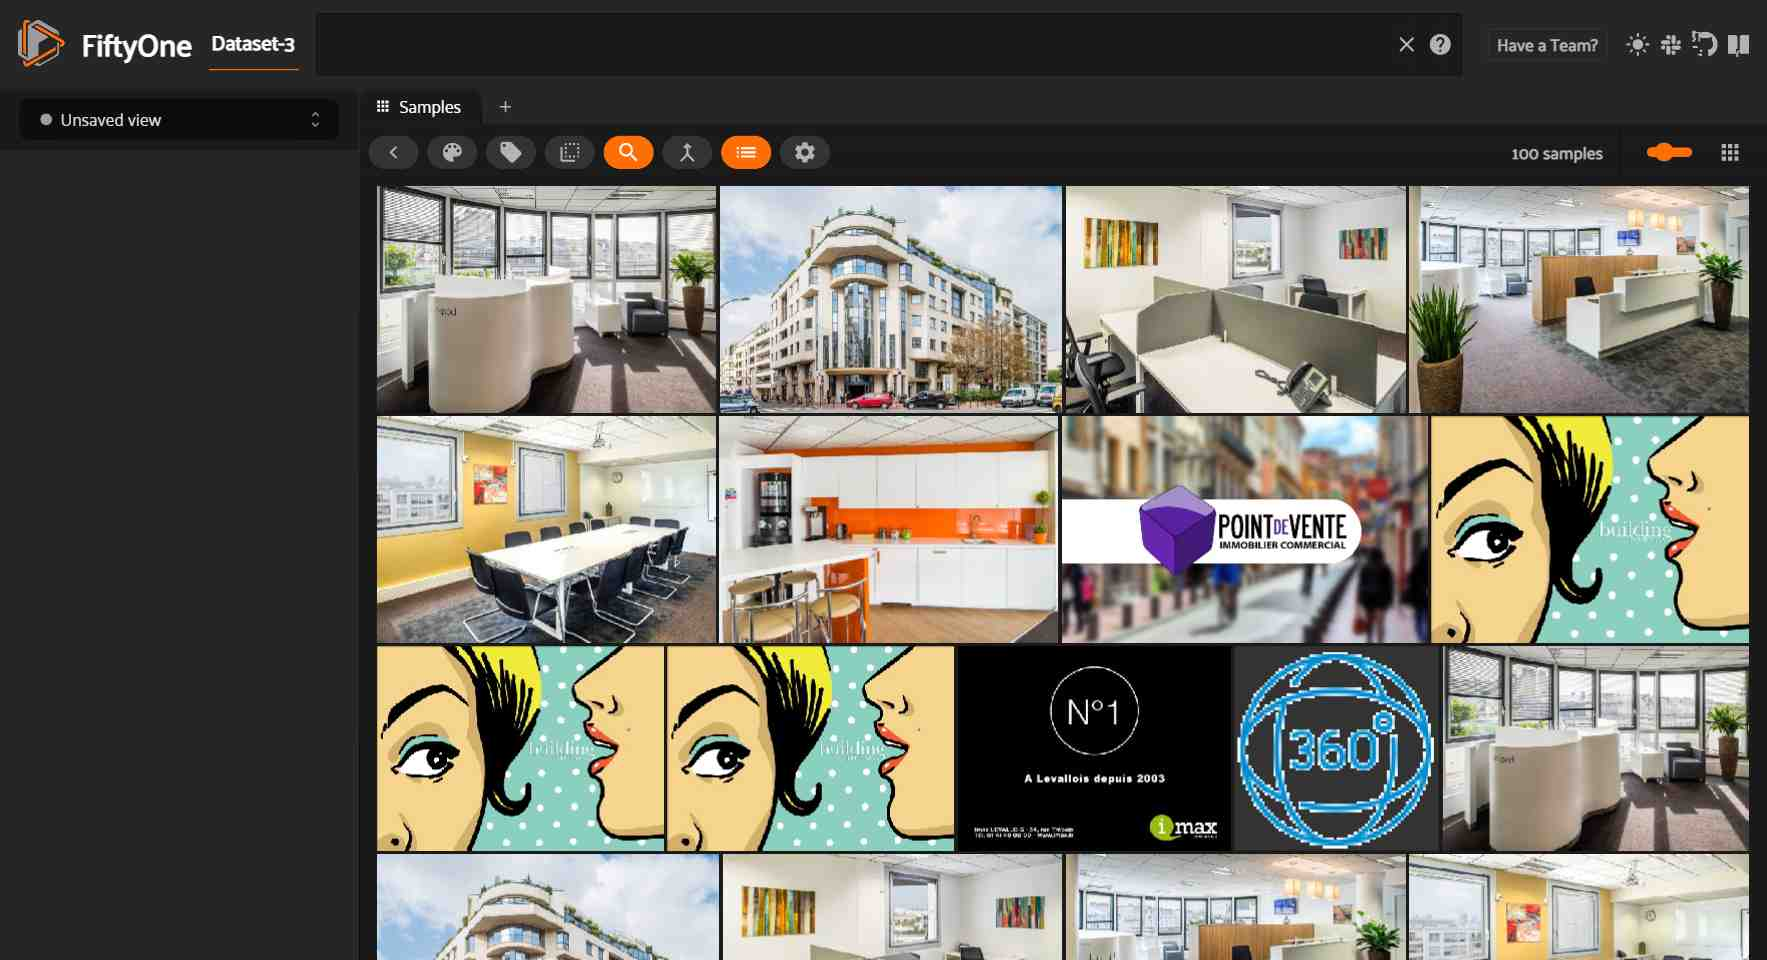


Could not connect session, trying again in 10 seconds



In [ ]:
session.view = dataset.sort_by("uniqueness").limit(100)


In [ ]:

filehash_counts = Counter(sample.file_hash for sample in dataset)
dup_filehashes = [k for k, v in filehash_counts.items() if v > 1]

len(dup_filehashes)

791

In [ ]:
dataset

Name:        Dataset-2
Media type:  image
Num samples: 8682
Persistent:  False
Tags:        []
Sample fields:
    id:        fiftyone.core.fields.ObjectIdField
    filepath:  fiftyone.core.fields.StringField
    tags:      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    file_hash: fiftyone.core.fields.IntField
    ID:        fiftyone.core.fields.StringField

In [ ]:
dataset.sort_by_similarity(100)


TypeError: 'int' object is not iterable

In [ ]:
def get_id_by_hash(dataset, file_hash):
    ids=[]
    for sample in dataset :
        if sample.file_hash==file_hash:
            ids.append(sample.ID)
            dataset.remove(sample)
    return ids

In [ ]:
duplicates=[]
for sample in tqdm(dataset):
    file_hash = sample.file_hash
    if file_hash in dup_filehashes:
        ids = get_id_by_hash(dataset, file_hash)
        duplicates.append(
            {
                "ID":sample.ID,
                "DUPLICATE_IDS":ids,
                "N_DUPLICATES":len(ids)
            }
        )


  0%|          | 0/8682 [00:00<?, ?it/s]

  0%|          | 16/8682 [00:00<00:09, 885.24it/s]


AttributeError: 'Dataset' object has no attribute 'remove'

In [ ]:


print("Number of duplicate file hashes: %d" % len(dup_filehashes))

dup_view = (dataset
    # Extract samples with duplicate file hashes
    .match(F("file_hash").is_in(dup_filehashes))
    # Sort by file hash so duplicates will be adjacent
    .sort_by("file_hash")
)

print("Number of images that have a duplicate:", len(dup_view))
print("Number of duplicates: ", (len(dup_view) - len(dup_filehashes)))
session = fo.launch_app()
session.view = dup_view

session.wait()

Number of duplicate file hashes: 791
Number of images that have a duplicate: 2055
Number of duplicates:  1264


RuntimeError: Failed to post event `state_update` to http://localhost:5151/event